In [1]:
import os
import json
import numpy as np
import pandas as pd

# plotting modules
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    return

In [3]:
combos_files = [
    "/data5/deepro/ukbiobank/papers/bmi_project/3_run_rarecomb/lifestyle_white_british/data/parsed_tables/combo_3.csv",
    "/data5/deepro/ukbiobank/papers/bmi_project/3_run_rarecomb/lifestyle_white_british/data/parsed_tables/combo_4.csv"
]
gencode_file = '/data5/bx_reference/hg38/annotations/gene_annotations/GENCODE39/gencode.v39.parsed.genes.tsv'

neuro_genes = ["DNAH1", "DNAH2", "DNAH5", "DNAH7", "DNAH9", "DNAH11", "DNAH17", "APC", "PC", "CAPN1", "COX6B2", "ITPR1", "PRPH", "RYR3", "TUBA3D"] 
dnah_genes = neuro_genes[:7]
other_neuro = neuro_genes[7:]

In [4]:
def join_array(xarr):
    xarr = sorted([i for i in xarr if not pd.isnull(i)])
    return "||".join(xarr)

def get_all_items_combos_samples(combos_files, max_combo=4, firstn=5, genes_of_interest=[]):
    combos_df = pd.concat([pd.read_csv(cf) for cf in combos_files])
    if not genes_of_interest:
        combos_df = combos_df.sort_values("Effect_Size").head(firstn)
    else:
        # get any combination that contains the genes of interest
        combos_df = combos_df.loc[combos_df.loc[:, [f"Item_{i}_symbol" for i in range(1, max_combo+1)]].apply(lambda row: row.str.fullmatch("|".join(genes_of_interest), case=False, na=False)).any(axis=1)]
        # Store the gene ids of all the genes from the selected combinations
    # assign combo numbers
    combos_df["combo_num"] = range(len(combos_df))
    # melt the combos df to get all items
    melted_combos_df = combos_df.melt(id_vars=["combo_num"], value_vars=[f"Item_{i}_symbol" for i in range(1, max_combo+1)]).drop(columns=["variable"])
    # one hot encode the melted combos df
    combos_plot_df = pd.get_dummies(melted_combos_df, columns=["value"], prefix="", prefix_sep="").groupby("combo_num").agg(sum)
    gene_cols = [c for c in combos_plot_df.columns if not c.startswith("diet") and not c.startswith("physical_activity")]
    other_cols = [c for c in combos_plot_df.columns if c.startswith("diet") or c.startswith("physical_activity")]
    combo_sample_dict = dict(zip(combos_df.combo_num, combos_df.Case_Samples))
    combos_plot_df["samples"] = combos_plot_df.index.map(combo_sample_dict)
    return combos_plot_df.reset_index().set_index(["combo_num", "samples"]), gene_cols, other_cols


def create_profile_plot(profile_pivot_selected, ngene_cols, nother_cols, third_col="Obesity_risk", figsize=(10, 3.5), map1_cmap=["w", "k"], map2_cmap="Greys", map3_cmap=["k"], ):
    fig, ax = plt.subplots(1,3, figsize=figsize, gridspec_kw={'width_ratios': [len(ngene_cols), len(nother_cols), 1]})
    g1 = sns.heatmap(
        data=profile_pivot_selected.loc[:, ngene_cols], 
        linewidths=0.05,
        linecolor="grey", 
        cbar=False,
        cmap=map1_cmap, # "w", "#ab162a" 
        ax=ax[0],
        yticklabels=False,
        square=False,
        )
    g2 = sns.heatmap(
        data=profile_pivot_selected.loc[:, nother_cols], 
        linewidths=0.05,
        linecolor="grey", 
        cbar=False,
        cmap=map2_cmap, #["w", "k"], # "w", "#ab162a", "grey",
        ax=ax[1],
        yticklabels=False,
        square=False,
        )

    g3 = sns.heatmap(
        data=(profile_pivot_selected.loc[:, third_col]>1).to_frame(), 
        linewidths=0.05,
        linecolor="w", 
        cbar=False,
        cmap=map3_cmap, # "#ab162a"
        ax=ax[2],
        yticklabels=False,
        square=False,
        )

    ax[0].set_ylabel("")
    ax[1].set_ylabel("")
    ax[2].set_ylabel("")
    ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90)
    ax[2].yaxis.tick_right()
    ax[2].set_yticks(np.arange(len(profile_pivot_selected)) + 0.5, profile_pivot_selected.loc[:, third_col].map(lambda x: f"(n={x})"), rotation=0)
    return fig, ax

In [5]:
combos_plot_df, gene_cols, other_cols = get_all_items_combos_samples(combos_files, genes_of_interest=neuro_genes)

In [6]:
combos_plot_df["Obesity_risk"] = [len(c.split(",")) for c in combos_plot_df.index.get_level_values(1)]

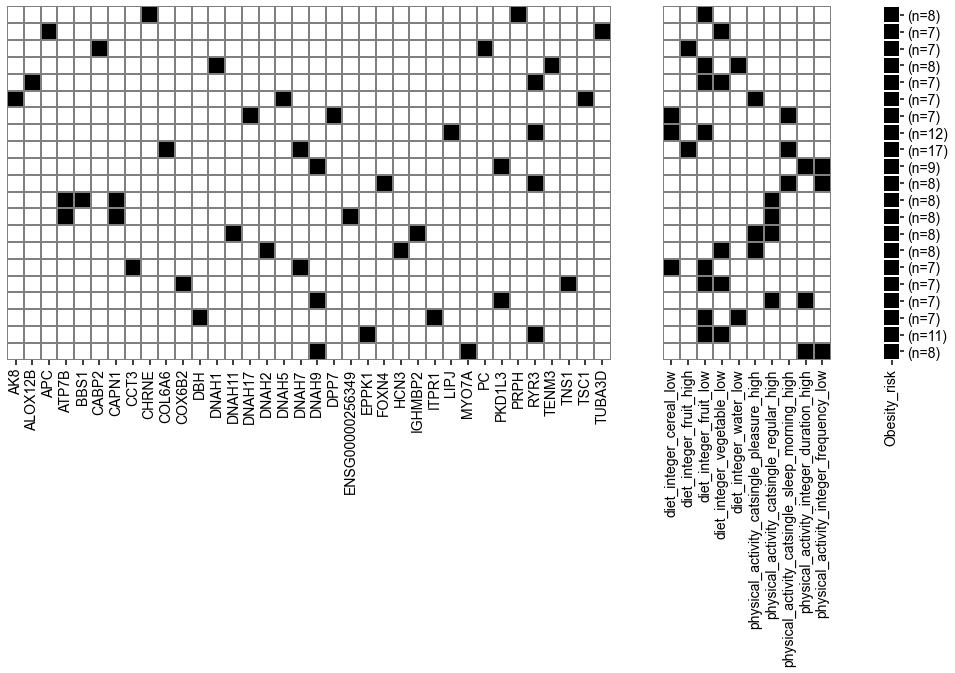

In [7]:
fig, ax = create_profile_plot(combos_plot_df, gene_cols, other_cols, figsize=(16, 6.5))

In [ ]:
save_file = "/data5/deepro/ukbiobank/papers/bmi_project/4_characterization/lifestyle_white_british/data/profiles/neuro_genes.pdf"
save_pdf(save_file, fig)

# Old code, will archive soon

In [27]:
def get_gencode_dict(gencode_file):
    gencode = pd.read_csv(gencode_file, sep='\t', low_memory=False)
    gencode["gene_id_stripped"] = gencode["gene_id"].str.split(".", expand=True)[0]
    gene_symbol_dict = dict(zip(gencode.gene_id_stripped, gencode.gene_name))
    return gene_symbol_dict

def edit_profile_df_colnames(colnames, gene_symbol_dict):
    new_gene_cols = []
    new_icd_cols = []
    new_colnames = []
    for c in colnames:
        if c.startswith("Input_ENSG"):
            item_name = gene_symbol_dict[c.replace("Input_", "")]
            new_gene_cols.append(item_name)
        else:
            if c != "Obesity_risk":
                item_name = c.replace("Input_", "")
                new_icd_cols.append(item_name)
            else:
                item_name = c
        new_colnames.append(item_name)
    return new_colnames, new_gene_cols, new_icd_cols

def modify_profile(profile_df):
    # add their obesity risk profile
    profile_df["Obesity_risk"] = 1
    # edit the profile df columns so that it makes more sense
    gene_symbol_dict = get_gencode_dict(gencode_file)
    profile_df.columns, ngene_cols, nother_cols =  edit_profile_df_colnames(profile_df.columns, gene_symbol_dict)
    profile_pivot = profile_df.pivot_table(index=ngene_cols, aggfunc=np.sum).reset_index()
    profile_pivot_selected = profile_pivot.loc[profile_pivot.Obesity_risk>=1]
    return profile_pivot_selected, ngene_cols, nother_cols

    

In [28]:
dnah_genes_profile_file = "/data5/deepro/ukbiobank/papers/bmi_project/4_characterization/lifestyle_white_british/data/profiles/dnah_genes.csv"
dnah_genes_profile_df = pd.read_csv(dnah_genes_profile_file, index_col=0)

In [29]:
dnah_genes_profile_df, dnah_genes_profile_gene_cols, dnah_genes_profile_other_cols = modify_profile(dnah_genes_profile_df)

(<Figure size 720x720 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

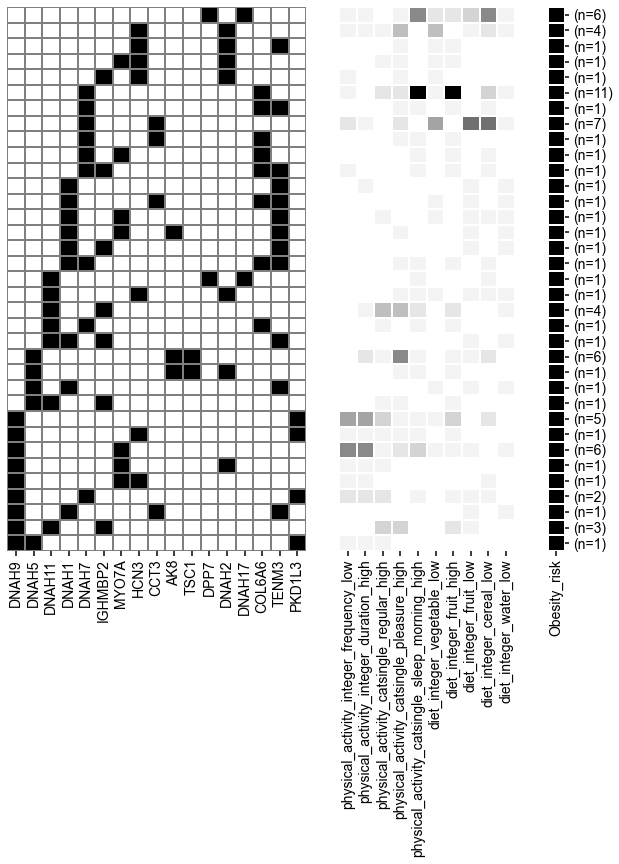

In [32]:
create_profile_plot(dnah_genes_profile_df, dnah_genes_profile_gene_cols, dnah_genes_profile_other_cols, figsize=(10, 10))

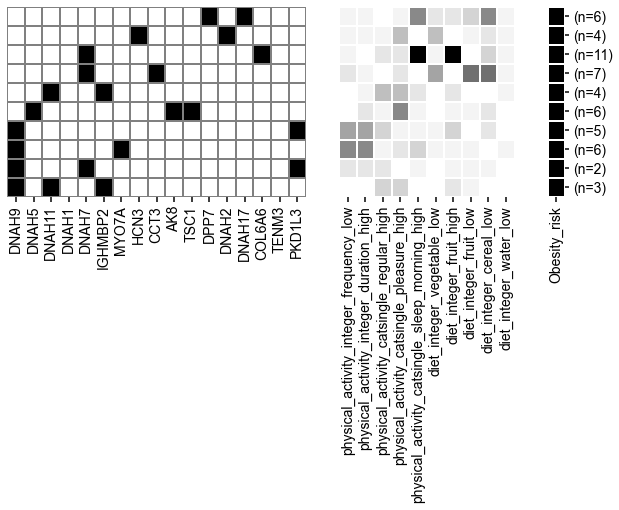

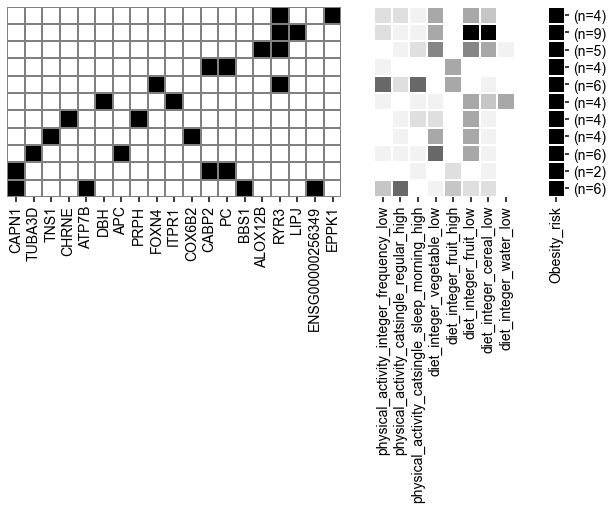

In [8]:
for goi in [dnah_genes, other_neuro]:
    # create plot
    # create_profile_plot(profile_pivot_selected, ngene_cols, nother_cols)